In [1]:
# Get mnist data
# Use morphomnist to plot the intensity
# Choose a distribution

In [2]:
# This path should get us to the root dir of the project
ROOT_PATH = '../../../'
MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist/'
DATA_ZIP = 'train-images-idx3-ubyte.gz'

In [3]:
%matplotlib inline
import sys
import os
import multiprocessing

import pyro
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append(ROOT_PATH)

In [4]:
print(sys.path)

['/Users/rajatrasal/Documents/University/Year 4/project/deepscm/deepscm/datasets/morphomnist', '/Users/rajatrasal/anaconda3/envs/proj/lib/python38.zip', '/Users/rajatrasal/anaconda3/envs/proj/lib/python3.8', '/Users/rajatrasal/anaconda3/envs/proj/lib/python3.8/lib-dynload', '', '/Users/rajatrasal/anaconda3/envs/proj/lib/python3.8/site-packages', '/Users/rajatrasal/anaconda3/envs/proj/lib/python3.8/site-packages/IPython/extensions', '/Users/rajatrasal/.ipython', '../../../']


In [5]:
from deepscm.morphomnist.io import load_idx

In [6]:
def get_intensity(img):
    threshold = 0.5

    img_min, img_max = img.min(), img.max()
    mask = (img >= img_min + (img_max - img_min) * threshold)
    avg_intensity = np.median(img[mask])

    return avg_intensity

In [7]:
int_thick_data = pd.read_csv(MNIST_DATA_PATH + 'train-morpho.csv', index_col='index')

labels = load_idx(MNIST_DATA_PATH + 'train-labels-idx1-ubyte.gz')
labels_df = pd.DataFrame(labels, columns=['label'])

morphology_data = pd.merge(int_thick_data, labels_df, left_index=True, right_index=True)
morphology_data.head()

,thickness,intensity,label
index,,,
0,2.398951,162.27393,5
1,2.789006,171.67532,0
2,2.655154,206.75359,4
3,2.852611,210.85230,1
4,1.750898,119.96817,9


In [8]:
morphology_data.label.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

<Figure size 720x720 with 0 Axes>

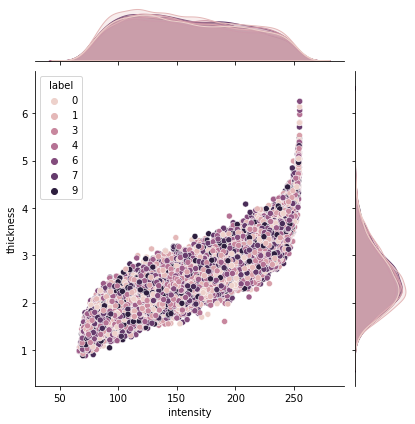

In [9]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data, x="intensity", y="thickness", hue="label")
plt.show()

<Figure size 720x720 with 0 Axes>

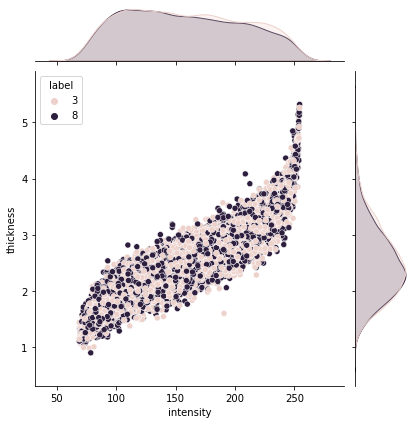

In [10]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data[morphology_data.label.isin([3, 8])], x="intensity", y="thickness", hue="label")
plt.show()

<Figure size 720x720 with 0 Axes>

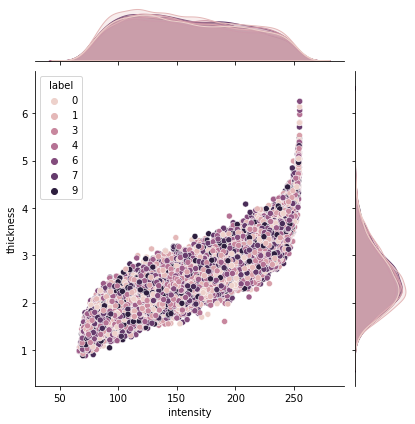

In [11]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data, x="intensity", y="thickness", hue="label")
plt.show()

In [12]:
morphology_data.intensity.describe()

count    60000.000000
mean       158.015839
std         48.379701
min         66.601204
25%        117.041938
50%        154.245835
75%        197.563997
max        254.903170
Name: intensity, dtype: float64

In [13]:
64 + 191

255

In [14]:
from scipy.optimize import curve_fit

In [15]:
def transformed_sigmoid(data, scale=0.5, shift=2):
    return 191 * (1 / (1 + np.exp(-(scale * data + shift)))) + 64

In [16]:
from collections import Counter

intensities = morphology_data.intensity.to_numpy()
counter = Counter(intensities.astype('int'))

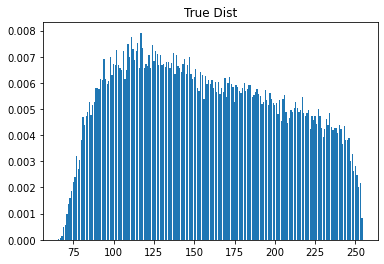

In [17]:
plt.title('True Dist')
plt.bar(counter.keys(), np.array(list(counter.values())) / 60000)
plt.show()

In [18]:
upper = intensities.max() - intensities.min()
lower = intensities.min()
upper, lower

(188.301966, 66.601204)

In [19]:
z = np.log((190 / (intensities - 66)) - 1)
loc = z.mean()
scale = z.var()

In [20]:
loc, scale

(0.049305123027108086, 1.8374342091632498)

In [21]:
from pyro.distributions import Normal, Gamma

In [22]:
with pyro.plate('intensity_observations', 60000):
    norm = Normal(0, 1)
    gam = Gamma(10, 5)
    z = pyro.sample('x', norm)
    y = pyro.sample('y', gam)
    
yy = 0.5 * z + 2 * y - 4

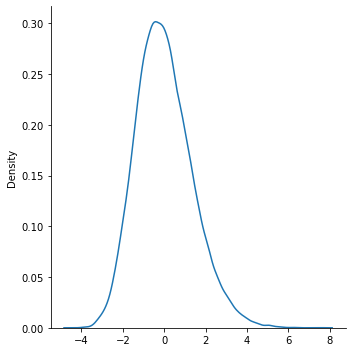

In [23]:
sns.displot(yy, kind="kde")

## Find parameters for the true data generating process of Intensity

In [24]:
import pyro

from pyro.distributions import Categorical, Normal, Gamma, TransformedDistribution, constraints, LogisticNormal
from pyro.distributions.transforms import SigmoidTransform, AffineTransform, ComposeTransform, ExpTransform
from pyro.infer import SVI

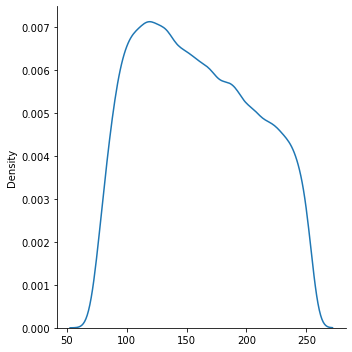

In [25]:
import torch
from torch.distributions import constraints


def intensity_dist(n_samples=60000):
    with pyro.plate('intensity_observations', n_samples):
        transforms = ComposeTransform([
            SigmoidTransform(),
            AffineTransform(66., 190.)]
        )
        
        noise1 = Normal(0, 1)
        noise2 = Gamma(10, 5)
        noise1_sample = pyro.sample('noise1', norm)
        noise2_sample = pyro.sample('noise2', gam)
        noise_rv = 0.5 * noise1_sample + 2 * noise2_sample - 4
        
    return transforms(noise_rv)
    # transformed_normal = TransformedDistribution(noise_rv, transforms)
    # intensity = pyro.sample("intensity", transformed_normal)
    # return intensity

intensity_samples = intensity_dist(60000)
sns.displot(intensity_samples, kind='kde')
plt.show()

In [26]:
transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
flow_dist = TransformedDistribution(Normal(-0.15, 1.3), transforms)

In [27]:
def intensity_dist_prior(X):
    mu = torch.Tensor(-0.15)
    sigma = torch.Tensor(1.3)
    with pyro.plate('intensity_observations', len(X)):
        transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
        transformed_normal = TransformedDistribution(Normal(mu, sigma), transforms)
        intensity = pyro.sample("intensity", transformed_normal, obs=X)
    return intensity

def intensity_dist_guide(X):
    mu = torch.Tensor(-0.15)
    sigma = torch.Tensor(1.3)
    with pyro.plate('intensity_observations', len(X)):
        transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
        transformed_normal = TransformedDistribution(Normal(mu, sigma), transforms)
        intensity = pyro.sample("intensity", transformed_normal, obs=X)
    return intensity

In [28]:
with pyro.plate('x', 60000):
    thickness = 0.5 + pyro.sample('intensity', Gamma(10., 5.))
    loc = (thickness - 2.5) * 2
    print(loc.mean())
    transforms = ComposeTransform([SigmoidTransform(), AffineTransform(64, 191)])
    norm = pyro.sample('x', Normal(loc, 0.5))
    intensity = pyro.sample('intensity', TransformedDistribution(Normal(loc, 0.5), transforms))

tensor(-0.0083)


In [29]:
x = Counter(norm.numpy().astype('int'))
y = Counter(loc.numpy().astype('int'))

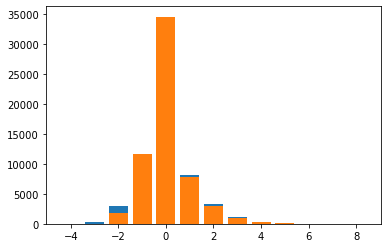

In [30]:
plt.bar(x.keys(), x.values())
plt.bar(y.keys(), y.values())
plt.show()

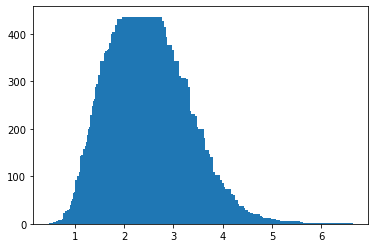

In [31]:
x2 = Counter(np.round(thickness.numpy(), 2))
plt.bar(x2.keys(), x2.values())
plt.show()

## Generate thickness from intensity

In [32]:
gm = Gamma(10., 550.)

counts = np.array([110 * pyro.sample('t', gm) + 0.5 for i in range(60000)])

In [33]:
counter = Counter(counts.round(2))

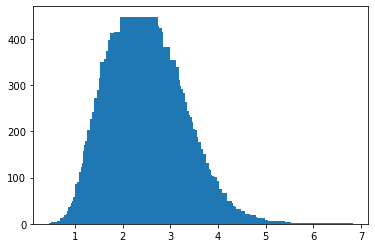

In [34]:
plt.bar(counter.keys(), counter.values())
plt.show()

In [35]:
morphology_data.thickness.describe()

count    60000.000000
mean         2.503249
std          0.631763
min          0.875985
25%          2.048362
50%          2.434765
75%          2.888612
max          6.255515
Name: thickness, dtype: float64

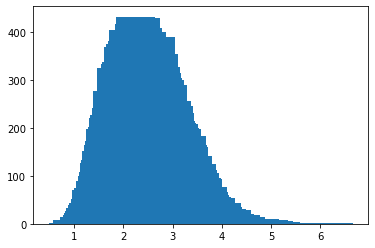

In [36]:
counts_thickness = Counter(np.round(morphology_data.thickness, 2))

plt.bar(counts_thickness.keys(), counts_thickness.values())
plt.show()

In [45]:
mode = Counter(morphology_data.intensity.astype('int')).most_common(1)[0][0]

In [46]:
intensity_sample_counts = Counter()

correction = morphology_data.intensity.median() + mode
correction /= 2

In [47]:
def thickness_dist(intensity, samples):
    with pyro.plate('obs', samples):
        rate = 5 * (intensity / correction)
        shape = 10  # * (intensity / correction)
        gamma = Gamma(shape, rate)
    return pyro.sample("thickness", gamma) + 0.5

In [48]:
samples = thickness_dist(torch.Tensor(intensity_samples[:60000]), 60000)

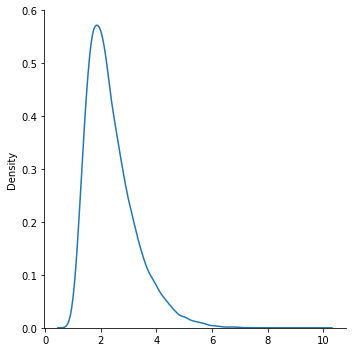

In [49]:
thickness_sample_counts = Counter(samples.numpy().round(2))
sns.displot(samples, kind='kde')

## Generate labels

<BarContainer object of 10 artists>

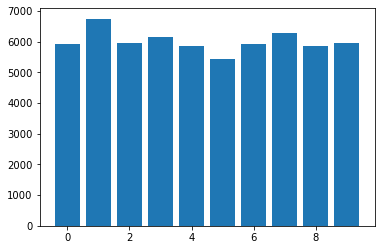

In [50]:
labels = Counter(morphology_data.label)
plt.bar(labels.keys(), labels.values())

In [51]:
label_counts = np.array(sorted(list(labels.items())))
label_counts

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

In [52]:
torch.Tensor(label_counts[:, 1] / morphology_data.shape[0])

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [53]:
labels_dist = Categorical(torch.Tensor(label_counts[:, 1] / morphology_data.shape[0]))

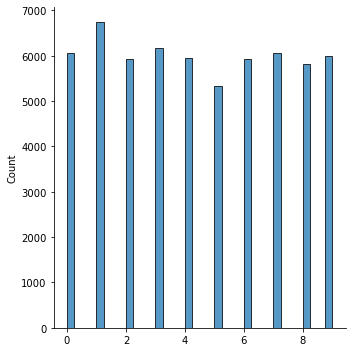

In [54]:
labels_samples = np.array([pyro.sample('labels', labels_dist) for i in range(60000)])
sns.displot(labels_samples)
plt.show()

## Full Data Generating Process

In [77]:
def model(n_samples=60000):
    with pyro.plate('observations', n_samples):
        intensity_transform = ComposeTransform([
            SigmoidTransform(),
            AffineTransform(66., 190.)]
        )
        
        normal_noise = pyro.sample('intensity_noise_normal', Normal(0, 1))
        gamma_noise = pyro.sample('intensity_noise_gamma', Gamma(10, 5))
        intensity_noise = 0.5 * normal_noise + 2 * gamma_noise - 4
        intensity = intensity_transform(intensity_noise)
        
        # thickness_transform = ComposeTransform([
        #     AffineTransform(-66/(190-66), 1/(190-66)),
        #     SigmoidTransform().inv,
        # ])
        
        # thickness_noise = pyro.sample('thickness_noise', Normal(0, 1))
        # thickness = (thickness_transform(intensity) + 5 - thickness_noise * 0.5) / 2
        
        noise = pyro.sample('thickness_noise', Normal(0, 1))
        # _i = intensity_transform.inv(intensities) 
        _i = (intensity - 66) / 190
        thickness = (-torch.log((1 / _i) - 1) + 5 - 0.5 * noise) / 2
        
        image_class_probs = [0.0987, 0.1124, 0.0993, 0.1022, 0.0974,
                             0.0904, 0.0986, 0.1044, 0.0975, 0.0992]
        labels = pyro.sample('labels', Categorical(torch.Tensor(image_class_probs)))
        
    return intensity, thickness, labels

<Figure size 720x720 with 0 Axes>

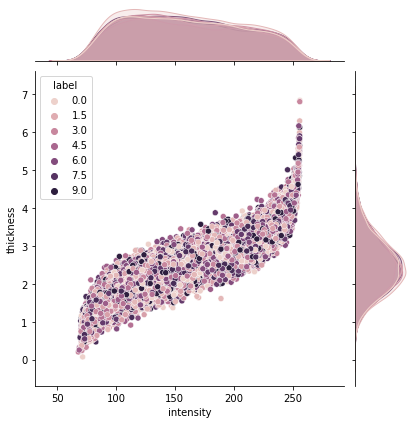

In [78]:
intensity, thickness, labels = model(60000)

generated_dataset = torch.stack([intensity, thickness, labels]).t().numpy()
generated_df = pd.DataFrame(generated_dataset, columns=['intensity', 'thickness', 'label'])

plt.figure(figsize=(10, 10))

sns.jointplot(data=generated_df, x="intensity", y="thickness", hue="label")
plt.show()